In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scribble notebook
The plan is to use this to make first experiments, which will later be turned into a cleaner implementation. 
For now, it is based on https://github.com/thomasantony/splat/blob/master/notes/00_Gaussian_Projection.ipynb 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import spatial
from typing import List, Dict 
from copy import deepcopy
import warnings 
import random 
from tqdm import tqdm 

from utils.Camera import Camera
from utils.util_gau import load_ply, naive_gaussian, GaussianData
from utils.constants import * 
from pathlib import Path 
import multiprocessing as mp 
import functools
from decouple import config
from dataclasses import dataclass 
from typing import List, Tuple

In [9]:
g_width, g_height = 100, 100

In [10]:
gaussians = naive_gaussian()

scale_modifier = 1.0       


## the below implementation has/had some parts which I do not fully understand, and I suspect there may be optimizations to be made too.
class Gaussian:
    def __init__(
            self, 
            pos: np.array, 
            scale: np.array, # standard deviations of each independent gaussian to use here. They are rotated to give the correct covariance
            rot: np.array, # quaternions
            opacity, 
            sh, 
            camera: Camera=None
        ):
        self.pos = np.array(pos)
        self.scale = np.array(scale_modifier * scale)
        self.max_scale = self.scale.max()
        # Initialize scipy Quaternion from rot (s, x, y, z)
        self.rot = spatial.transform.Rotation.from_quat([rot[1], rot[2], rot[3], rot[0]])
        self.opacity = opacity[0] # why?
        self.sh = np.array(sh)
        self.cov3D = self.compute_cov3d()
        self.camera = camera

    def compute_cov3d(self):
        cov3D = np.diag(self.scale**2)
        cov3D = self.rot.as_matrix().T @ cov3D @ self.rot.as_matrix()
        return cov3D

    def get_pos_cam(self, camera: Camera) -> np.array:
        """Get the 4d position of the gaussian, as viewed by the camera"""
        view_mat = self.get_view_matrix(camera) # camera.get_view_matrix() # world space to view space # TODO: better to save this matrix and update it when necessary
        g_pos_w = np.append(self.pos, 1.0)
        g_pos_cam = view_mat @ g_pos_w
        return g_pos_cam

    def _update_camera(self, camera: Camera):
        if camera:
            if not self.camera or np.linalg.norm(self.camera.position - camera.position) > 1e-4 or (self.camera.w - camera.w)**2 > 1e-4 or (self.camera.h - camera.h)**2 > 1e-4:
                self.camera = camera

    def get_view_matrix(self, camera: Camera=None):
        self._update_camera(camera)
        if not hasattr(self, 'view_matrix') or camera: self.view_matrix = self.camera.get_view_matrix()
        return self.view_matrix
        # return camera.get_view_matrix()
    
    def get_projection_matrix(self, camera: Camera=None):
        self._update_camera(camera)
        if not hasattr(self, 'projection_matrix') or camera: self.projection_matrix = self.camera.get_view_matrix()
        return self.view_matrix
        # return camera.get_projection_matrix()


    def get_cov2d(self, camera: Camera=None) -> np.ndarray:
        # g_pos_cam = self.get_pos_cam(camera)
        view_matrix = self.get_view_matrix(camera)
        if camera is None: camera = self.camera
        [htan_fovx, htan_fovy, focal] = camera.get_htanfovxy_focal() # I guess this has to do with perspective rendering, but not sure

        # Implementation inspired by https://www.songho.ca/opengl/gl_projectionmatrix.html
        # We are assuming for all objects that l=r, t=u (see link for definition)
        n = focal # I admit this is slightly hacky, but we project to the focus plane, and I think the other implementation also had some issues
        f = -focal 
        h = camera.h
        w = camera.w
        J = np.array(
            [
                [n/w * 2, 0., 0., 0.],  # TODO: w or h?
                [0., n/h * 2, 0., 0.],  # TODO: w or h?
                [0., 0., -(n+f) / (f-n), 0.-2*n*f/(f - n)],
                [0., 0., -1., 0.]
            ]
        )[:3, :3] # ignore w
        W = view_matrix[:3, :3].T
        T = W @ J
        cov = T.T @ self.cov3D.T @ T

        return cov[:2, :2] # Are we merely omitting w here?

    def get_depth(self, camera: Camera):
        """Get the perceived distance to the objects, as seen from the camera"""
        view_matrix = camera.get_view_matrix() 
        
        position4 = np.append(self.pos, 1.0) # last component is w factor, with which we divide to account for objects looking smaller in perspective projections
        g_pos_view = view_matrix @ position4
        depth = g_pos_view[2]
        return depth
    
    def get_optimal_bb(self, camera: Camera, thresh: float=3., conic=None):
        # "inverse" of covariance - can be used to find active areas for each gaussian
        if conic is None:
            cov2d = self.get_cov2d(camera) # covariance

            det = np.linalg.det(cov2d)
            
            det_inv = 1.0 / max([1e-6, det]) # instead of comparing det == 0. as was done earlier
            cov = [cov2d[0,0], cov2d[0,1], cov2d[1,1]] # unique elements of covariance matrix
            conic = np.array([cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv])
        
        # optimal bounding box: maximize x and y with the constraint -(ksi-mu)^T Sigma^-1 (ksi - mu) = -2*thresh^2, where ksi=(x, y), mu = 0 (centered Gaussian) and Sigma is the covariance
        # we can use a trick by observing that when y is maximal, and the above constraint holds, then there is a unique value of x such that the equation is satisfied.
        # satisfying the constraint means 
        # x = -p/2 +- sqrt(p^2 - 4q), with p = 2y c[1]/c[0], q = (y^2 c[2] / c[0] - 2thresh^2) , c = conic
        # So p^2 - 4q must be 0, meaning 
        # y^2 c1^2 / c0^2 - (y^2 c2 - 2t^2)/c0 = 0
        # y^2 (c1^2 / c0^2 - c2/c0) = - 2t^2/c0
        # y = +- sqrt(2) t/(sqrt(- c1^2 / c0 + c2)) 

        c0, c1, c2 = conic
        y_opt = thresh / (np.sqrt(-c1**2 / c0 + c2)) * np.sqrt(2)
        x_opt = thresh / (np.sqrt(-c1**2 / c2 + c0)) * np.sqrt(2)
        bboxsize_cam = np.array([x_opt, y_opt]) # bounds on coordinate values of 3 sigma ellipse level set. NOT ndc
        return bboxsize_cam

    def get_fast_bb(self, thresh: float=3.):
        bboxsize_cam = thresh*np.array([self.max_scale] * 2) # not pretty, but fast and correct. Could solve optimization problem based on conv2d instead (fix a level set and find the maximum value of x/y)
        return bboxsize_cam

    def get_conic_and_bb(self, camera: Camera, thresh:float=3., optimal:bool=False):
        """Get conic and other bounding boxes. Is this implementation sound?"""
        cov2d = self.get_cov2d(camera) # covariance

        det = np.linalg.det(cov2d)
        
        det_inv = 1.0 / max([1e-6, det]) # instead of comparing det == 0. as was done earlier
        cov = [cov2d[0,0], cov2d[0,1], cov2d[1,1]] # unique elements of covariance matrix
        conic = np.array([cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv])

        if not optimal: 
            bboxsize_cam = self.get_fast_bb(thresh)
        else:
            bboxsize_cam = self.get_optimal_bb(camera, thresh, conic)
        wh = np.array([camera.w, camera.h])
        bboxsize_ndc = np.divide(bboxsize_cam, wh) * 2 # ndc coords (should be [-1, 1]^2). This makes no sense; it assumes that sigma already "lives in the wh space"
        
        vertices = np.array([[-1, 1], [1, 1], [1, -1], [-1, -1]]) # this is actually unneccessary... TODO
        bboxsize_cam = np.multiply(vertices, bboxsize_cam) # assuming bboxsize_cam has bounds on x and y for the ellipse, this bounds ul, ur, ll, lr. In principle, that's unneccesary as it uses 8, and not 4, coords (TODO)
        g_pos_ndc = self.get_pos_ndc(camera)
        
        bbox_ndc = np.multiply(vertices, bboxsize_ndc) + g_pos_ndc[:2]
        bbox_ndc = np.hstack((bbox_ndc, np.zeros((vertices.shape[0],2)))) # concatenate bbox with "dummy" zeros
        bbox_ndc[:,2:4] = g_pos_ndc[2:4] # replace the dummy zeros above with z and w from clip position of gaussian. TODO: This is strange, in light of the way we define bboxsize_cam 
        
        
        # bbox_ndc, bboxsize_cam = self.get_bb_ndc(camera, thresh)
        return conic, bboxsize_cam, bbox_ndc
    
    def get_pos_ndc(self, camera: Camera):
        """ndc pos, it seems, based on code in get_conic_bb"""
        # compute g_pos_screen and gl_position
        view_matrix = self.get_view_matrix(camera)# camera.get_view_matrix()
        projection_matrix = self.get_projection_matrix(camera) # camera.get_projection_matrix() # MAKE NDC

        position4 = np.append(self.pos, 1.0)
        g_pos_view = view_matrix @ position4
        g_pos_screen = projection_matrix @ g_pos_view # aka g_pos_clip
        g_pos_screen = g_pos_screen / g_pos_screen[3] 
        return g_pos_screen

    def get_color(self, dir) -> np.ndarray:
        """Samples spherical harmonics to get color for given view direction"""
        c0 = self.sh[0:3]   # f_dc_* from the ply file)
        color = SH_C0 * c0

        shdim = len(self.sh)

        if shdim > 3:
            # Add the first order spherical harmonics
            c1 = self.sh[3:6]
            c2 = self.sh[6:9]
            c3 = self.sh[9:12]
    
            x = dir[0]
            y = dir[1]
            z = dir[2]
            color = color - SH_C1 * y * c1 + SH_C1 * z * c2 - SH_C1 * x * c3
            
        if shdim > 12:
            c4 = self.sh[12:15]
            c5 = self.sh[15:18]
            c6 = self.sh[18:21]
            c7 = self.sh[21:24]
            c8 = self.sh[24:27]
    
            (xx, yy, zz) = (x * x, y * y, z * z)
            (xy, yz, xz) = (x * y, y * z, x * z)
            
            color = color +	SH_C2_0 * xy * c4 + \
                SH_C2_1 * yz * c5 + \
                SH_C2_2 * (2.0 * zz - xx - yy) * c6 + \
                SH_C2_3 * xz * c7 + \
                SH_C2_4 * (xx - yy) * c8

        if shdim > 27:
            c9 = self.sh[27:30]
            c10 = self.sh[30:33]
            c11 = self.sh[33:36]
            c12 = self.sh[36:39]
            c13 = self.sh[39:42]
            c14 = self.sh[42:45]
            c15 = self.sh[45:48]
    
            color = color + \
                SH_C3_0 * y * (3.0 * xx - yy) * c9 + \
                SH_C3_1 * xy * z * c10 + \
                SH_C3_2 * y * (4.0 * zz - xx - yy) * c11 + \
                SH_C3_3 * z * (2.0 * zz - 3.0 * xx - 3.0 * yy) * c12 + \
                SH_C3_4 * x * (4.0 * zz - xx - yy) * c13 + \
                SH_C3_5 * z * (xx - yy) * c14 + \
                SH_C3_6 * x * (xx - 3.0 * yy) * c15
        
        color += 0.5
        return np.clip(color, 0.0, 1.0)

    def get_prec(self, sigma: np.ndarray=None, camera: Camera=None) -> np.ndarray:
        if sigma is None: sigma = self.get_cov2d(camera)
        else: assert sigma.shape == (2, 2)
        det = np.linalg.det(sigma)
        if det < 1e-6:
            warnings.warn(f'{det=} is a bad condition number')
        det_inv = 1.0 / max([det, 1e-6])
        cov = [sigma[0,0], sigma[0,1], sigma[1,1]] # unique elements of covariance matrix
        conic = np.array([cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv]) 
        return conic 

    def get_exponent(self, x: np.array, camera: Camera=None, mu: np.array=None, sigma: np.ndarray=None) -> float: # TODO: make vectorized version
        if mu is None: 
            mu = self.get_pos_ndc(camera)[:2]
            mu = camera.ndc_to_pixel(mu)
        if sigma is None: 
            sigma = self.get_cov2d()
            sigma_ndc = sigma / np.array([camera.w, camera.h]) * 2
            sigma = camera.ndc_to_pixel(sigma_ndc)
        prec = self.get_prec(sigma)
        prec = np.array([[prec[0], prec[1]], [prec[1], prec[2]]])
        diff = (x - mu[:2]) / np.array([camera.w, camera.h]) # TODO: is this true?
        tmp = (prec @ diff)
        return - diff.T @ tmp / 2

# Iterate over the gaussians and create Gaussian objects
gaussian_objects = []
for (pos, scale, rot, opacity, sh) in zip(gaussians.xyz, gaussians.scale, gaussians.rot, gaussians.opacity, gaussians.sh):
    gau = Gaussian(pos, scale, rot, opacity, sh)
    gaussian_objects.append(gau)

## Define some classes for optimization

In [48]:
def plot_conics_and_bbs(gaussian_objects, camera: Camera, color: str='blue'):

    ax = plt.gca()

    for g in gaussian_objects: #zip(gaussian_objects, colors):
        assert isinstance(g, Gaussian)
        (conic, bboxsize_cam, bbox_ndc) = g.get_conic_and_bb(camera)
        if conic is None:
            continue

        A, B, C = conic
        # coordxy is the correct scale to be used with gaussian and is already
        # centered on the gaussian
        coordxy = bboxsize_cam
        x_cam = np.linspace(coordxy[0][0], coordxy[1][0], 100)
        y_cam = np.linspace(coordxy[1][1], coordxy[2][1], 100) # how come the first axis has more than 2 dimensions here?
        X, Y = np.meshgrid(x_cam, y_cam)
        
        # 1-sigma ellipse # actually, I think this is the sqrt(3)-sigma ellipse. 
        # F = A*X**2 + 2*B*X*Y + C*Y**2 - 3.00
        F = np.sqrt(A*X**2 + 2*B*X*Y + C*Y**2) - 3.00

        bbox_screen = camera.ndc_to_pixel(bbox_ndc)

        # Use bbox offset to position of gaussian in screen coords to position the ellipse
        x_px = np.linspace(bbox_screen[0][0], bbox_screen[1][0], 100)
        y_px = np.linspace(bbox_screen[2][1], bbox_screen[1][1], 100) # again, why this many dimensions?
        X_px, Y_px = np.meshgrid(x_px, y_px)
        F_val = 0.0
        plt.contour(X_px, Y_px, F, [F_val])

        # Plot a rectangle around the gaussian position based on bb
        ul = bbox_screen[0,:2]
        ur = bbox_screen[1,:2]
        lr = bbox_screen[2,:2]
        ll = bbox_screen[3,:2]
        ax.add_patch(plt.Rectangle((ul[0], ul[1]), ur[0] - ul[0], lr[1] - ur[1], fill=False, alpha=1., color=color))

@dataclass 
class SubImage:
    """This is a utility class for handling SubImages, i.e. a rectangular part of an Image"""
    image: np.ndarray 
    ul: tuple # upper left of sub-image
    lr: tuple # lower right of sub-image
    camera: Camera 
    def __init__(
        self, 
        image: np.ndarray, 
        ul: Tuple[float, float], 
        lr: Tuple[float, float], 
        camera: Camera
    ):
        self.image = image 
        self.ul = ul 
        self.lr = lr
        self.camera = camera 
        self.ymin, self.xmin = ul 
        self.ymax, self.xmax = lr 
        self.bounds = (self.xmin, self.xmax, self.ymin, self.ymax)
    
    def __getitem__(self, key):
        # if isinstance(key, tuple):
        #     key = tuple(np.s_[k] if isinstance(k, slice) else k for i, k in enumerate(key))
        if isinstance(key, tuple) and any([isinstance(k, slice) for k in key]): 
            ul = (0 if key[0].start is None else key[0].start, 0 if key[1].start is None else key[1].start)
            lr = (self.image.shape[0] if key[0].stop is None else key[0].stop,  self.image.shape[1] if key[1].stop is None else key[1].stop)
            key = tuple(np.s_[k] if isinstance(k, slice) else k for i, k in enumerate(key))
            return SubImage(self.image[key], ul, lr, self.camera)
        return self.image[key]
    
    @property
    def shape(self): return self.image.shape
    
class PrimitiveSet:
    """Set of primitives (e.g. gaussians)"""
    def __init__(
        self, 
        primitives: List[Gaussian] # TODO: for many applications, it would be nice to use a generator instead
    ):
        self.items = primitives
        self.indices = list(range(len(primitives)))
    
    def sample_ids(self, N:int):
        """sample randomly from self"""
        return random.sample(self.indices, N)
    
    def __len__(self):
        return len(self.items )

    def __getitem__(self, idx):
        return self.items[idx]

    def sort(self, camera):
        self.indices = np.argsort([gau.get_depth(camera) for gau in self.items]) 

class ImageSegmenter:
    """This class will find an optimal way to cut an image, minimizing the maximum number of primitives assigned to one side of the image."""
    pass 

class IterativeImageSegmenter:
    """This class will iteratively use ImageSegmenters to segment the image into multiple parts, which have a "balanced" number of primitives assigned to them"""
    def __init__(
        self, 
        subset: PrimitiveSet, 
        img: SubImage,
        camera: Camera,
        thresh: float=3.,
        
    ):
        self.subset = subset 
        self.img = img 
        self.thresh = thresh
        self.camera = camera
        self.cuts = [
            {'level': 0, 'responsibility': list(range(len(subset))), 'corners': (img.ul, img.lr)}
        ] # list of dicts with subimage coordinates, number of primitives belonging to this segment, and the "cut level" - how many larger sub-images is each sub image part of

    def cut(self, idx: int):
        """add another two subimages to self.cuts by finding an optimal cut of self.cuts[idx]"""
        item = self.cuts[idx]
        ul, lr = item['corners']
        subimage = self.img[ul[0]:lr[0], ul[1]: lr[1]]
        ss = [p for i, p in enumerate(self.subset) if i in item['responsibility']]
        bx, by = cut_image(subimage, ss, self.camera, thresh=self.thresh)
        if bx is not None:
            self.cuts.extend(
                [
                    {'level': item['level']+1, 'responsibility': self.get_ids(subimage[:, bx:]), 'corners': ((ul[0], bx), lr)}, # TODO: responsibility, and verify corners
                    {'level': item['level']+1, 'responsibility': self.get_ids(subimage[:, :bx]), 'corners': (ul, (lr[0], bx))}
                ]
            )
        else: 
            self.cuts.extend(
                [
                    {'level': item['level']+1, 'responsibility': self.get_ids(subimage[by:, :]), 'corners': ((by, ul[1]), lr)}, # TODO: responsibility, and verify corners
                    {'level': item['level']+1, 'responsibility': self.get_ids(subimage[:by, :]), 'corners': (ul, (by, lr[1]))}
                ]
            )
        return bx, by
    
    def get_ids(self, subimage: SubImage):
        return [i for i, p in enumerate(self.subset) if is_member(subimage, p, self.thresh, camera=self.camera)]

@dataclass 
class PrimitiveSubset:
    """A class that keeps track of a subset of Primitive objects"""
    ids: List[int]
    parent: PrimitiveSet 
    def __init__(
        self, 
        parent: PrimitiveSet, 
        ids: List[int]
    ):
        self.parent = parent 
        self.indices = ids 
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx): return self.parent[idx]
    def sample_ids(self, N: int): return random.sample(self.indices, N)

def cut_image(subimage: SubImage, subset: PrimitiveSubset, camera:Camera, tol: float=0.02, thresh:float=3) -> Tuple[float, float]:
    """Utility function that takes indices defined in gaussians and returns a tuple (x, y), where one is None, that optimally divides the picture"""
    # binary search to optimize the objective
    minmax_x = np.inf 
    xmin, xmax, ymin, ymax = subimage.bounds
    # search x 
    lower, upper = xmin, xmax
    if tol < 1: tol = tol * max(subimage.shape)
    l0 = len(subset)
    while upper - lower > tol:
        assert l0 == len(subset), f'{subset=}, {upper=}, {lower=}'
        middle = int((lower + upper) / 2)
        left_count = get_responsibility(subimage[:, :middle], subset, thresh, camera)
        right_count = get_responsibility(subimage[:, middle:], subset, thresh, camera)
        if max([left_count, right_count]) < minmax_x: 
            minmax_x = max([left_count, right_count]) 
            x_cut = middle 
        if left_count < right_count: 
            lower = middle
        else: 
            upper = middle 
    # search y
    lower, upper = ymin, ymax
    minmax_y = np.inf 
    while upper - lower > tol:
        assert l0 == len(subset), f'{subset=}, {upper=}, {lower=}'
        middle = int((lower + upper) / 2)
        left_count = get_responsibility(subimage[:middle, :], subset, thresh, camera)
        right_count = get_responsibility(subimage[middle:, :], subset, thresh, camera)
        if max([left_count, right_count]) < minmax_y: 
            minmax_y = max([left_count, right_count]) 
            y_cut = middle 
        if left_count < right_count: lower = middle
        else: upper = middle
    print(f'{minmax_x=}, {minmax_y=}')
    if minmax_x > minmax_y: return (None, y_cut)
    return (x_cut, None)

def get_responsibility(subimage: SubImage, subset: PrimitiveSubset, thresh: float, camera:Camera) -> int:
    """Compute the number of primitives in subset potentially assigned to subimage."""
    ss = [primitive for primitive in subset if is_member_bb(subimage, primitive, thresh, camera=camera)]
    # sss =[p for p in subset if not is_member_bb(subimage, p, thresh, camera=camera)]
    # print(subimage.bounds)
    # plot_conics_and_bbs(ss, camera, 'blue')
    # plot_conics_and_bbs(sss, camera, 'red')
    # plt.xlim([0, camera.w])
    # plt.ylim([0, camera.h])
    # plt.grid(True)
    # plt.show()
    return len(ss)

def is_member_bb(subimage: SubImage, primitive: Gaussian, thresh: float, mu: np.array=None, sigma: np.ndarray=None, camera: Camera=None) -> bool:
    # bbox_ndc = primitive.get_bb_ndc(camera, thresh, optimal=True)[0]
    bbox_ndc = primitive.get_conic_and_bb(camera, thresh, optimal=True)[-1]
    bbox_screen = camera.ndc_to_pixel(bbox_ndc)
    xmin, xmax, ymin, ymax = subimage.bounds
    ul = bbox_screen[0,:2]
    lr = bbox_screen[2,:2]
    intersect_x = xmax >= ul[0] >= xmin or xmax >= lr[0] >= xmin or lr[0] >= xmax >= xmin >=ul[0] # bounds lie within screen (first two), or screen lies within bounds (last)
    intersect_y = ymax >= lr[1] >= ymin or ymax >= ul[1] >= ymin or lr[1] <= ymin <= ymax <=ul[1]
    return intersect_x and intersect_y


def is_member(subimage: SubImage, primitive: Gaussian, thresh: float, mu: np.array=None, sigma: np.ndarray=None, camera: Camera=None) -> bool:
    """Does the primitive potentially belong in subimage?
    It seems that if sigma has big eigenvalues, we run into trouble. But let's just use the optimal bounding boxes we computed lol
    """
    def get_max_line(x: float, y: float):
        """for a fixed value of x or y, maximize the primitive on the specified line. Return the maximum value"""
        assert x is None or y is None and not (x is None and y is None)
        if x is None: 
            x = sigma[1, 0] / sigma[1, 1] * y 
        else:
            y = sigma[1, 0] / sigma[0, 0] * x 
        return primitive.get_exponent(np.array([x, y]), camera, mu, sigma)
    
    # if the mean is in the image, we assume that it's bright enough to be counted
    camera = subimage.camera
    if mu is None: 
        mu = primitive.get_pos_ndc(camera)[:2]
        mu = camera.ndc_to_pixel(mu) # translate to pixel coords
        
    xmin, xmax, ymin, ymax = subimage.bounds
    if xmin <= mu[0] <= xmax and ymin <= mu[1] <= ymax: return True

    # find the maximum value of the primitive on subimage
    if sigma is None: 
        sigma = primitive.get_cov2d(camera)
        # sigma_ndc = sigma / np.array([camera.w, camera.h]) * 2
        # sigma = camera.ndc_to_pixel(sigma_ndc)
    # if mu[0]<-1: print(mu) 
    res = max([
        get_max_line(xmin, None),
        get_max_line(xmax, None),
        get_max_line(None, ymin),
        get_max_line(None, ymax),
    ])
    return res >= -thresh
    

minmax_x=17, minmax_y=15
minmax_x=6, minmax_y=14
minmax_x=8, minmax_y=9
minmax_x=7, minmax_y=9
minmax_x=4, minmax_y=9
minmax_x=7, minmax_y=8
minmax_x=5, minmax_y=5


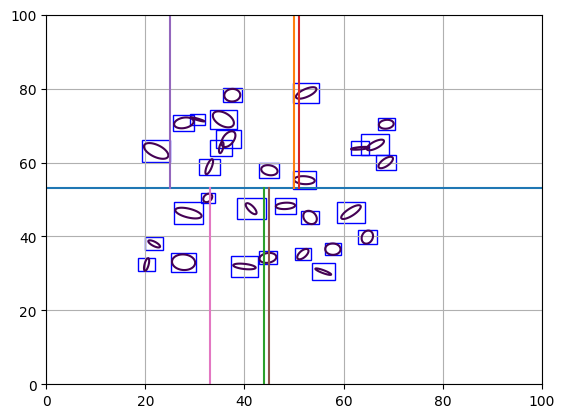

In [86]:
# Plot conic using equation A*x**2 + B*x*y + C*y**2 = 1
# where A, B, C are the conic parameters

# plot the boundary where the equation is satisfied

loc_scaler = 1
scale_scaler = 1
rot_scaler = 10
n_gaussians = 30
loc_bias = np.ones(3,) * -.1

gaussians_debug = [
    Gaussian((np.random.rand(3, )-.5 + loc_bias)*loc_scaler, np.random.rand(3)*scale_scaler, np.random.rand(4)*rot_scaler, np.array([1.]), np.array([ 1.772484, -1.772484,  1.772484])) for _ in range(n_gaussians)
]

fig = plt.figure()
ax = plt.gca()
camera = Camera(100, 100)
plot_conics_and_bbs(gaussians_debug, camera)
image = SubImage(np.zeros((100, 100)), (0, 0), (100, 100), camera)
pset = PrimitiveSet(gaussians_debug)
sset = PrimitiveSubset(pset, list(range(len(gaussians_debug))))
# bx, by = cut_image(image, sset, camera, thresh=3)
# if bx is None: 
#     plt.axhline(by)
# else: plt.axvline(bx)
segmenter = IterativeImageSegmenter(sset, image, camera, thresh=3)
# bx, by = segmenter.cut(0)
# if bx is None: 
#     plt.axhline(by)
# else: plt.axvline(bx)
for i in range(7):
    bx, by = segmenter.cut(i)
    ul, lr = segmenter.cuts[-1]['corners']
    ymin, xmin = ul
    ymax, xmax = lr 
    if bx is None:
        # plot y splitting line
        plt.plot([xmin, xmax], [by]*2)
    else:
        plt.plot([bx]*2, [ymin, ymax])
    
plt.xlim([0, camera.w])
plt.ylim([0, camera.h])
plt.grid(True)
plt.show()


In [13]:
def subroutine(enum, A, B, C, y_iter, opacity, alphas, bitmap, color, alpha_thresh, w, h):
    """This function was originally made so that I could parallellize plot_opacity, which turned out to be slower due
    to overhead computations, but I still kept this function to "refactor" the plot_opacity function"""
    # time.sleep(random.randint(0, 1000)/1000)
    if alpha_thresh is None: alpha_thresh = np.inf
    index, (x, x_cam) = enum
    x = min([alphas.shape[1]-1, max([x, 0])])
    alphas = alphas[:, x]
    bm = bitmap[:, x]
    if x < 0 or x >= w:
        return bm, alphas 
    for y, y_cam in y_iter: 
        if y < 0 or y >= h:
            continue

        # Gaussian is typically calculated as f(x, y) = A * exp(-(a*x^2 + 2*b*x*y + c*y^2))
        power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam # TODO: can be better by just computing the range for y up front
        if power > 0.0:
            continue

        alpha = opacity * np.exp(power)
        alpha = min(0.99, alpha) 
        # if opacity < 1.0 / 255.0:
        #     continue

        # Set the pixel color to the given color and opacity
        # Do alpha blending using "over" method # TODO: not sure if this is correct? It would make more sense if it were old_alpha + (1-old_alpha)*alpha, no?
        old_alpha = alphas[y]
        new_alpha = alpha + old_alpha * (1.0 - alpha) 
        alphas[y] = new_alpha
        bm[y, :] = (color[0:3]) * alpha + bm[y, :] * (1.0 - alpha)
        if alpha_thresh is not None and new_alpha > alpha_thresh: break 
    return bm, alphas 

def plot_opacity(gaussian: Gaussian, camera: Camera, bitmap: np.ndarray, alphas: np.ndarray, alpha_thresh: float=None, n_threads:int=1, responsible_range=None):
    """Compute the opacity of a gaussian given the camera"""
    shp = bitmap.shape
    w, h = camera.w, camera.h
    conic, bboxsize_cam, bbox_ndc = gaussian.get_conic_and_bb(camera) # different bounding boxes (active areas for gaussian)

    A, B, C = conic # precision matrix is (A, B; B, C)

    screen_height, screen_width = bitmap.shape[:2]
    bbox_screen = camera.ndc_to_pixel(bbox_ndc, screen_width, screen_height)
    
    if np.any(np.isnan(bbox_screen)):
        return

    ul = bbox_screen[0,:2] # Bounding box vertices 
    ur = bbox_screen[1,:2]
    lr = bbox_screen[2,:2]
    ll = bbox_screen[3,:2]
    
    y1 = int(np.floor(ul[1]))
    y2 = int(np.ceil(ll[1]))
    
    x1 = int(np.floor(ul[0]))
    x2 = int(np.ceil(ur[0]))
    nx = x2 - x1
    ny = y2 - y1

    # Extract out inputs for the gaussian
    coordxy = bboxsize_cam
    x_cam_1 = coordxy[0][0]   # ul
    x_cam_2 = coordxy[1][0]   # ur
    y_cam_1 = coordxy[1][1]   # ur (y)
    y_cam_2 = coordxy[2][1]   # lr

    camera_dir = gaussian.pos - camera.position
    camera_dir = camera_dir / np.linalg.norm(camera_dir) # normalized camera viewing direction
    color = gaussian.get_color(camera_dir)


    if responsible_range is not None:
        x_iter = [(x, x_cam) for x, x_cam in zip(range(x1, x2), np.linspace(x_cam_1, x_cam_2, nx)) if x in responsible_range]
    else: x_iter = zip(range(x1, x2), np.linspace(x_cam_1, x_cam_2, nx))
    for tpl in x_iter: # TODO: better to provide this range explicitly or for each x computing the relevant y's
        x, cam = tpl
        bm, al = subroutine((None, tpl), A, B, C, zip(range(y1, y2), np.linspace(y_cam_1, y_cam_2, ny)), opacity, alphas, bitmap, color, alpha_thresh, w=w, h=h)
        bitmap[:, x] = bm 
        # print(f'{bm.sum()=}')
        alphas[:, x] = al
    # print(f'{bitmap.max()=}, {bitmap.sum()=}. {alphas.max()=}, {alphas.sum()=}')
    return bitmap, alphas

# # Iterate over the gaussians and create Gaussian objects
# gaussian_objects = []
# for (pos, scale, rot, opacity, sh) in zip(gaussians.xyz, gaussians.scale, gaussians.rot, gaussians.opacity, gaussians.sh):
#     gau = Gaussian(pos, scale, rot, opacity, sh)
#     gaussian_objects.append(gau)

# (h, w) = (300, 400)
# camera = Camera(h, w)
# # Get gaussian indices sorted by depth
# indices = np.argsort([g.get_depth(camera) for g in gaussian_objects])

# # Initialize a bitmap with alpha channel of size w x h

# bitmap = np.zeros((h, w, 3), np.float32)
# alphas = np.zeros((h, w), np.float32)

# plt.figure(figsize=(6,6))
# for idx in indices:
#     bitmap, alphas = plot_opacity(gaussian_objects[idx], camera, bitmap, alphas, n_threads=3)
# print(f'after execution, {bitmap.max()=}')
# # Plot the bitmap
# plt.imshow(bitmap, vmin=0, vmax=1.0)

# plt.show()

In [14]:

def helper(rng, indices, camera, bitmap, alphas, alpha_thresh):
    if not rng: return 
    for idx in tqdm(indices):
        bitmap, alphas = plot_opacity(gaussian_objects[idx], camera, bitmap, alphas, alpha_thresh, responsible_range=rng)
    return np.stack([bitmap[:, x] for x in rng], axis=0)

def plot_model_par(camera, gaussian_objects: List[Gaussian], alpha_thresh: float=None, n_threads:int=1):
    def partition_matrix(mat: np.ndarray):
        s = max([mat.shape[0] // n_threads, 1])
        if s == 1: return [mat[i:i+1] for i in range(mat.shape[0])]
        return [mat[s*i: s*(i+1)] for i in range(n_threads-1)] + [mat[s*(n_threads-1):]]
    print('Sorting the gaussians by depth')
    indices = np.argsort([gau.get_depth(camera) for gau in gaussian_objects]) # fast
    w, h = camera.w, camera.h
    
    print('Plotting with', len(gaussian_objects), 'gaussians')
    bitmap = np.zeros((h, w, 3), np.float32)
    bitmap_parts = partition_matrix(bitmap)
    alphas = np.zeros((h, w), np.float32)
    alphas_parts = partition_matrix(alphas)
    # step = w // n_threads
    # ranges = [range(step * i, step*(i+1)) for i in range(n_threads - 1)] + [range(step * (n_threads - 1), w)]
    # ranges = [[step*i+offset for i in range(int(w / step))] for offset in range(n_threads)]
    ranges = [range(offset, w, n_threads) for offset in range(n_threads)]
    print(ranges)
    # TODO: the below could possibly be paralellized by splitting the resulting image into tiles and rendering them in parallell
    # (I think they do that in the paper too)
    with mp.Pool(n_threads) as pool:
        results = pool.map(
            functools.partial(
                helper,
                indices=indices,
                alpha_thresh=alpha_thresh, 
                camera=camera,# None,
                bitmap=bitmap,
                alphas=alphas
            ), 
            ranges
        )
        # for idx in tqdm(indices): # TODO: this is slow and could potentially be sped up by manipulating the chosen gaussians
        #     bitmap, alphas = plot_opacity(gaussian_objects[idx], camera, bitmap, alphas, alpha_thresh)
    for res, rng in zip(results, ranges):
        if res is None: continue
        for i, idx in enumerate(rng): bitmap[:, idx] = res[i]

    return bitmap



In [15]:
model = load_ply(str(Path(config('MODEL_PATH'))/'debug/point_cloud/iteration_30000/point_cloud.ply'))
from tqdm import tqdm

print('Loading gaussians ...')
gaussian_objects = []
(h, w) = (100, 100)
camera = Camera(h, w, position=(-0.6, 2.99040512, -0.2), target=(-1.0, 0.0, 0.0))
for (pos, scale, rot, opacity, sh) in tqdm(zip(model.xyz, model.scale, model.rot, model.opacity, model.sh)):
    gaussian_objects.append(Gaussian(pos, scale, rot, opacity, sh))

Loading gaussians ...


281498it [00:07, 36966.39it/s]


Sorting the gaussians by depth
Plotting with 281498 gaussians
[range(0, 100, 6), range(1, 100, 6), range(2, 100, 6), range(3, 100, 6), range(4, 100, 6), range(5, 100, 6)]


100%|██████████| 281498/281498 [01:25<00:00, 3283.78it/s]


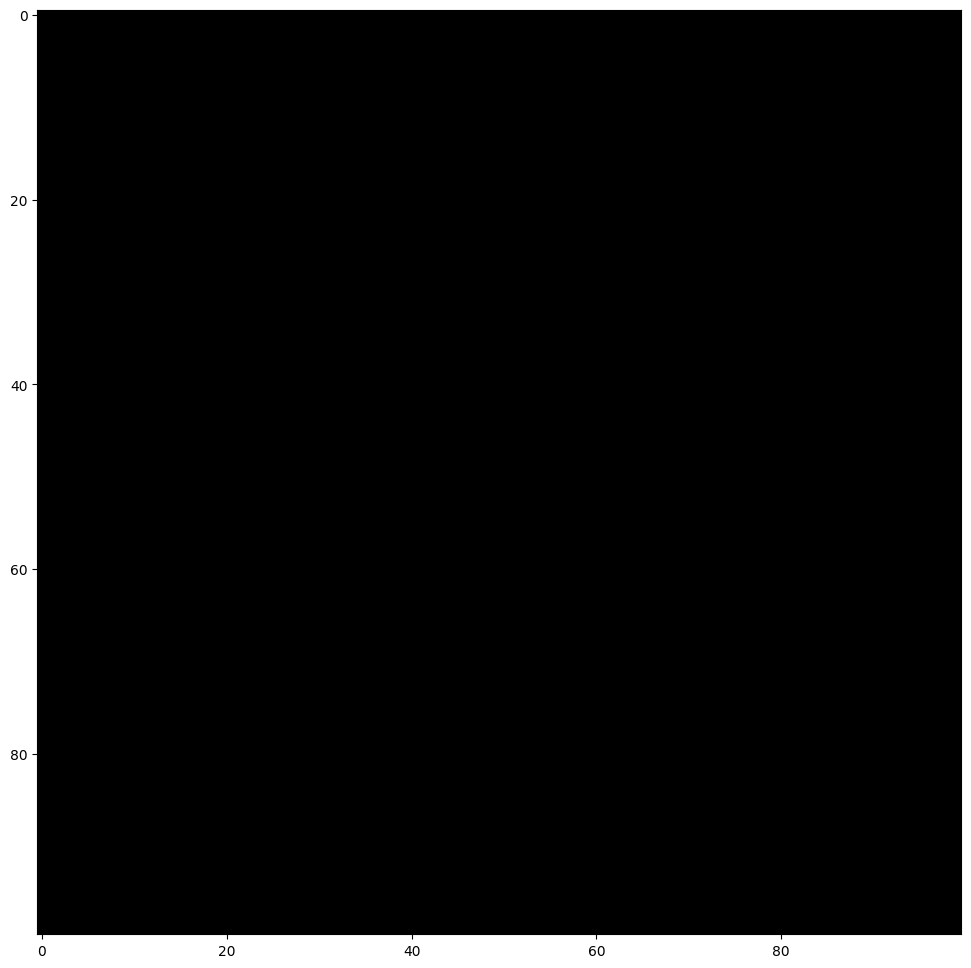

In [16]:
alpha_thresh = None
# camera = Camera(h, w, position=(0.94, 1.29, -2.65), target=(0.0, 0.66, 0.07))
bitmap = plot_model_par(camera, gaussian_objects, alpha_thresh=alpha_thresh, n_threads=6)

plt.figure(figsize=(12, 12))
plt.imshow(bitmap, vmin=0, vmax=1.0)
plt.show()